---
title: 'Simulation and Plotting'
toc: true
number-sections: true
mainfont: Arial
format:
  html: default
jupyter: python3
---

In [1]:
#| echo: false
#| output: false
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(r"..\..\src")

The following tutorial introduces dynamic simulations (RMS/EMT), plotting and exporting of results (to pandas or csv) using *powfacpy*.

Let's again set up *PowerFactory* and create an instance of *powfacpy*'s `Plots` class. This class inherits from `ActiveProject` (so those methods are available). We use the '39-Bus New England' example from *PowerFactory* (see File->Examples).

In [2]:
import sys

sys.path.append(
    r"C:\Program Files\DIgSILENT\PowerFactory 2023 SP5\Python\3.11"
)  # you may use a different directory
# Get the PF app
import powerfactory

app = powerfactory.GetApplication()
from powfacpy.applications.plots import Plots

app.Show()
app.ActivateProject(
    r"powfacpy\39_bus_new_england_copy_where_tests_run"
)  # You may change the project path.

pfplt = Plots(app)
study_case = pfplt.act_prj.activate_study_case(
    r"Study Cases\2.1 Simulation Fault Bus 16 Stable"
)

# Plotting Inside *PowerFactory*

In *PowerFactory*, monitored result variables (to be later plotted or exported) need to be specified before the simulation. The easiest way to plot results using *powfacpy* is to simply use the method `plot` before the simulation, which automaticallly adds a variable to the monitored variables and plots it as soon as the simulation has run.

First, we set the active plot (starting from a clean graphics board by clearing all plot pages).

In [3]:
pfplt.clear_plot_pages()  # Start from a clean graphics board
pfplt.set_active_plot("Plot 1", "Plot page 1")

The method `set_active_plot` takes the name of the plot and the name of the page of the plot as input arguments. If the plot (or the page) does not exist, it is created. If there should be several plots on one page, the method is called several times with the same page name but different plot name (e.g. `pfplt.set_active_plot("Plot 2", "Plot page 1")`). 

All plot commmands are applied to the active plot. We can now add curves to the plot.

In [4]:
# Curve of variable "s:P1"
pfplt.plot(r"Network Model\Network Data\Grid\G 01", "s:P1")

# Curve of variable "s:Q1"
g_01 = pfplt.act_prj.get_unique_obj(r"Network Model\Network Data\Grid\G 01")
results_obj = pfplt.act_prj.get_unique_obj(
    r"Study Cases\2.1 Simulation Fault Bus 16 Stable\All calculations"
)
# Plot with keyword arguments
pfplt.plot(
    g_01,  # obj or str
    "s:Q1",
    linestyle=3,
    linewidth=200,
    color=5,
    label="Reactive power setpoint",
    results_obj=results_obj,
)

**NOTE:** If the plot is not shown properly in *PowerFactory*, click on refresh  and rescale .

The method `plot` takes the PF object (or its path) and a results variable as first and second input. Furthermore, keyword arguments can be specified as shown for the second curve. 

Now we can execute a dynamic simulation using the `DynamicSimulations` interface class.

In [5]:
from powfacpy.applications.dynamic_simulation import DynamicSimulation

pfds = DynamicSimulation(app)
pfds.initialize_sim({"iopt_sim": "rms"})
pfds.run_sim({"tstop": 0.5})

The two methods initialize and run the simulation. Paramters for the ComInc object (initialization) and the ComSim (run simulation) can be specified in a dictionary. If no parameters need to be set, one can also use:

In [6]:
pfds.initialize_and_run_sim()

In some cases, it might be more convenient to add the result variable first, then simulate and finally specifiy the plot:

In [7]:
pfplt.clear_curves()
pfds.initialize_sim({"iopt_sim": "rms"})
pfds.act_prj.add_results_variable(g_01, "s:P1")
pfds.run_sim()
pfplt.plot_monitored_variables(g_01, "s:P1")

So the method `add_results_variable` is used to add variables to the monitored vaiables to later export or plot them.

*powfacpy* offers more functionality that are helpful in this context. The `ResVar` class offers enumeration subclasses for results variables of various simulation types (e.g. RMS balanced/unbalanced, EMT, load flow balanced/unbalanced). The names of *PowerFactory* result variables can be cryptic. The enumeration classes offer an easy way to get the names and also their short description (just hover over `s_P1` in `RMS_bal.ElmSym.s_P1` in the cell below). Code completion in your IDE helps you find the variable you want without having to look it up in *PowerFactory*. The syntax is

`simulation_type`.`class_name`.`variable_name`.`value`

e.g.

- `RMS_bal.ElmSym.s_P1.value`
- `RMS_bal.ElmSym.m_Psum_bus1.value` .

In the variable name, colons (":") are replaced by underscores ("_") to comply with python naming restrictions. The `value` at the end is required to get the name string of the variable. It is assumed that you set `RMS_bal = ResVar.RMS_Bal` as in the cell below.


Additionally, `create_dyn_sim_event` in the cell below creates an event, here we add a parameter event. 

In [8]:
from powfacpy.result_variables import ResVar

RMS_bal = ResVar.RMS_Bal  # we focus on balanced RMS simulation here

pfplt.clear_curves()
pfds.initialize_sim({"iopt_sim": "rms"})
pfds.act_prj.add_results_variable(g_01, RMS_bal.ElmSym.s_P1.value)
pfds.create_dyn_sim_event(
    "Set_turbine_power_of_g01.EvtParam",
    {"p_target": g_01, "variable": "pt", "value": "0.5", "time": 0},
)
pfds.run_sim()
pfplt.plot_monitored_variables(g_01, RMS_bal.ElmSym.s_P1.value)

Sometimes we have created plots in one study case and want to have those plots also in another study case. This can be achieved by copying the graphics board content (or parts of it) from one study case to another:

In [9]:
study_case_1 = pfplt.act_prj.get_unique_obj(
    r"Study Cases\2.1 Simulation Fault Bus 16 Stable"
)
study_case_2 = pfplt.act_prj.get_unique_obj(
    r"Study Cases\2.2 Simulation Fault Bus 16 Unstable"
)

pfplt.copy_graphics_board_content(study_case_1, study_case_2, "*.GrpPage")

This copies all plot pages (class GrpPage) of Study Case 1 to Study Case 2. The target study case argument can also be a list of cases. Or we can use the method `copy_graphics_board_content_to_all_study_cases` to target all study cases or all cases in a certain folder.

# Getting Objects from the Initial Conditions Calculation (ComInc)
A common source of error is that users access wrong objects from the active study case without noticing. For example, they access a `Results Object (ElmRes)` which they assume to be used in their time-domain simulation, but actually multiple `ElmRes` objects exist in the study case and the `Initial Conditions Calculation (ComInc)` uses a different one to store simualion results.

This can be avoided by getting the objects directly from the `ComInc`:

In [10]:
elmres = pfplt.act_prj.get_results_obj_from_initial_conditions_calc()
events_folder = pfplt.act_prj.get_events_folder_from_initial_conditions_calc()

# Exporting Results from *PowerFactory*

Simulation results can be exported to a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) via the class `Results`.

In [11]:
from powfacpy.applications.results import Results

pfres = Results(app)

## Export to Pandas DataFrame
Let's export dynamic simulation results to a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). We'll hide the *PowerFactory* app to improve the performance.

In [12]:
try:
    app.Hide()
    pfds.act_prj.clear_elmres()
    pfds.act_prj.add_results_variable(
        [
            r"Network Model\Network Data\Grid\G 01",
            r"Network Model\Network Data\Grid\G 02",
        ],
        [RMS_bal.ElmSym.s_P1.value, RMS_bal.ElmSym.s_Q1.value],
    )
    pfds.initialize_and_run_sim()
    df_sim_res = pfres.export_to_pandas()
finally:
    app.Show()
df_sim_res.head(3)

Grid\G 01              Grid\G 02            
           s:P1       s:Q1        s:P1        s:Q1
time                                              
-0.10    1000.0  88.281415  520.811072  198.251784
-0.09    1000.0  88.281415  520.811072  198.251784
-0.08    1000.0  88.281415  520.811072  198.251784

Multi index column labels are used by default. The first index is the path of the object inside the network data folder and the second index is the variable name.

You can also use single index column format:

In [13]:
pfres.multi_index_labels = False
df_sim_res = pfres.export_to_pandas()
df_sim_res.head(3)

,Grid\G 01\s:P1,Grid\G 01\s:Q1,Grid\G 02\s:P1,Grid\G 02\s:Q1
time,,,,
-0.10,1000.0,88.281415,520.811072,198.251784
-0.09,1000.0,88.281415,520.811072,198.251784
-0.08,1000.0,88.281415,520.811072,198.251784


It is also possible to set the actual PF objects as labels:

In [14]:
pfres.pf_objects_in_labels = True
pfres.multi_index_labels = True
df_sim_res = pfres.export_to_pandas()
df_sim_res.head(3)

<l3>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Network Model.IntPrjfolder\Network Data.IntPrjfolder\Grid.ElmNet\G 01.ElmSym</l3>  \
                                                                                                                                                                  s:P1   
time                                                                                                                                                                     
-0.10                                             1000.0                                                                                                                 
-0.09                                             1000.0                                                                                                                 
-0.08                                             1000.0                                                                                                                 

                  \
            s:Q1   
time               
-0.10  88.281415   
-0.09  88.281415   
-0.08  88.281415   

      <l3>\seberlein.IntUser\powfacpy\39_bus_new_england_copy_where_tests_run.IntPrj\Network Model.IntPrjfolder\Network Data.IntPrjfolder\Grid.ElmNet\G 02.ElmSym</l3>  \
                                                                                                                                                                  s:P1   
time                                                                                                                                                                     
-0.10                                         520.811072                                                                                                                 
-0.09                                         520.811072                                                                                                                 
-0.08                                         520.811072                                                                                                                 

                   
             s:Q1  
time               
-0.10  198.251784  
-0.09  198.251784  
-0.08  198.251784

The column headers are the path of the objects relative to the network data folder (by default) together with the result variable name. You can change the relative path by setting the attribute `pfres.truncate_paths_until` (relative to active project):  


In [15]:
pfres.multi_index_labels = True
pfres.pf_objects_in_labels = False
pfres.truncate_paths_until = "Network Model\\Network Data\\Grid\\"
df_sim_res = pfres.export_to_pandas()
df_sim_res.head(3)

G 01                   G 02            
         s:P1       s:Q1        s:P1        s:Q1
time                                            
-0.10  1000.0  88.281415  520.811072  198.251784
-0.09  1000.0  88.281415  520.811072  198.251784
-0.08  1000.0  88.281415  520.811072  198.251784

*powfacpy* offers methods to easily extract results from the exported pandas DataFrame using *PowerFactory* objects instead of columns headers (**note that changing the format of the column headers of the DataFrame after export will break this functionality**):

,G 01
,s:P1
time,
-0.10,1000.0
-0.09,1000.0
-0.08,1000.0


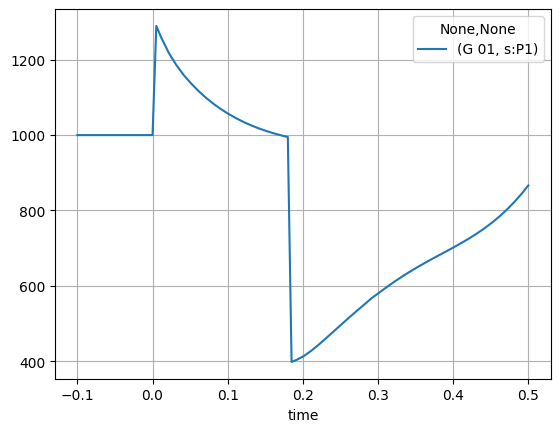

In [16]:
import matplotlib.pyplot as plt

p_g_01 = pfres.get_simulation_results_from_dataframe(
    df_sim_res,
    g_01,  # accepts using PF objects of their path inside the active project)
    RMS_bal.ElmSym.s_P1.value,
)
p_g_01.plot(grid=True)
p_g_01.head(3)

Let's look a more complicated example where you want to examine the active and reactive power of the synchronous machines `G 01` and `G 02`.  

In [17]:
# SM objects
sm_objs = [
    pfres.act_prj.get_unique_obj(r"Network Model\Network Data\Grid\G 01"),
    pfres.act_prj.get_unique_obj(r"Network Model\Network Data\Grid\G 02"),
]

# Results variables
sm_res_var = [RMS_bal.ElmSym.s_P1.value, RMS_bal.ElmSym.s_Q1.value]

pfres.act_prj.clear_elmres()
pfres.act_prj.add_results_variable(sm_objs, sm_res_var)
pfdi = DynamicSimulation(app)
pfdi.initialize_and_run_sim()

We want to add a legend to the plots. As the default variable and object names might not be very descriptive, *powfacpy* allows to define aliases, e.g. to be used later for labels in plots:

In [18]:
pfres.variable_aliases = {
    RMS_bal.ElmSym.s_P1.value: "Active Power",
    RMS_bal.ElmSym.s_Q1.value: "Reactive Power",
}  # note that RMS_bal.ElmSym.s_P1.value gives 's:P1'

pfres.obj_aliases = {
    "G 01": "Synch. Maschine 1 (large)",
    "G 02": "Synch. Maschine 2",
}

Let's see how the `variable_aliases` dictionary can then be used when plotting active and reactive power of `G 01` using `replace_variable_aliases`:

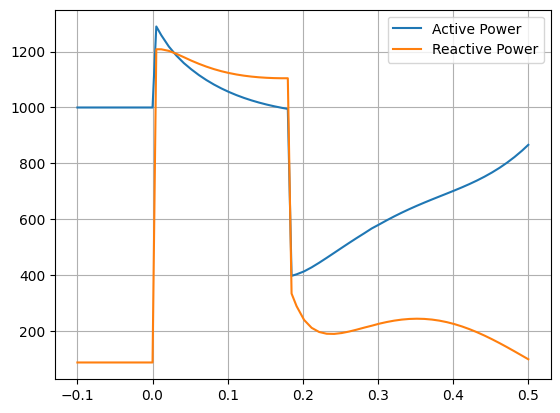

In [19]:
df_sim_res = pfres.export_to_pandas()
for var in sm_res_var:
    res = pfres.get_simulation_results_from_dataframe(df_sim_res, sm_objs[0], var)
    label = pfres.replace_variable_aliases(var)
    plt.plot(res, label=label)
plt.legend()
plt.grid()

Instead of `s:P1` or `s:Q1`, the replacements defined in the dictionaries above are used for the labels.

Or in a similar fashion, using also the `object_aliases` to plot the reactive power of both machines:

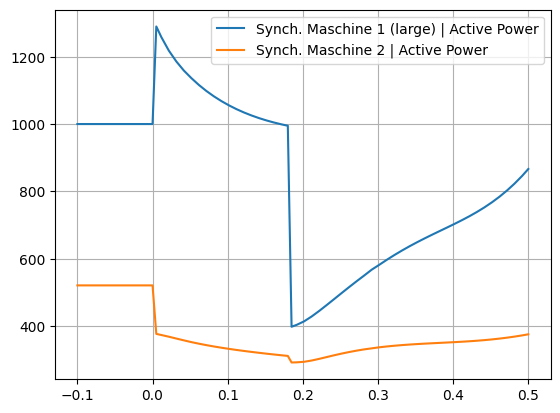

In [20]:
var = RMS_bal.ElmSym.s_P1.value
for sm in sm_objs:
    res = pfres.get_simulation_results_from_dataframe(df_sim_res, sm, var)
    label = (
        pfres.replace_object_aliases(sm.loc_name)
        + " | "
        + pfres.replace_variable_aliases(var)
    )
    plt.plot(res, label=label)
plt.legend()
plt.grid()

Hence, the dictionaries are a clean option to define aliases and reuse them anywhere in your code.

Note that `get_simulation_results_from_dataframe` also accepts a list of objects (as well as a list of variables). You can easily get various time series results and then process the data using pandas (e.g. calculate mean or average):  

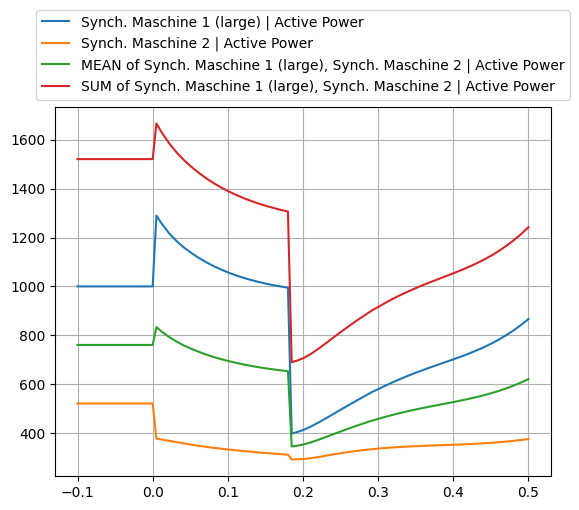

In [21]:
var = RMS_bal.ElmSym.s_P1.value
res = pfres.get_simulation_results_from_dataframe(
    df_sim_res, sm_objs, var  # list with G 01 and G 02
)

mean = res.mean(1)  # pandas method to get mean over axis 1
sum = res.sum(1)

# Plot active power of individual SMs
for sm_num, sm_obj in enumerate(sm_objs):
    label = (
        pfres.replace_object_aliases(sm_obj.loc_name)
        + " | "
        + pfres.replace_variable_aliases(var)
    )
    plt.plot(res.iloc[:, sm_num], label=label)

# Plot mean and sum
label_sms = ", ".join([pfres.replace_object_aliases(sm.loc_name) for sm in sm_objs])
label = "MEAN of " + label_sms + " | " + pfres.replace_variable_aliases(var)
plt.plot(mean, label=label)
label = "SUM of " + label_sms + " | " + pfres.replace_variable_aliases(var)
plt.plot(sum, label=label)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0))
plt.grid()

Note that the same code block can be used with other result variables (e.g. reactive power) just by changing the `var` assignment in the first line.

By default, `export_to_pandas` exports all monitored variables of the first `ElmRes` object found in the active study case. Alternatively, selections of network elements and the respective variables as well as results objects (`ElmRes`) can be specified as lists:

In [22]:
elements = [g_01, g_01]
variables = [RMS_bal.ElmSym.s_P1.value, RMS_bal.ElmSym.s_Q1.value]
elmres_list = [pfres.act_prj.get_results_obj_from_initial_conditions_calc()] * len(
    variables
)

df_sim_res = pfres.export_to_pandas(
    list_of_results_objs=elmres_list, elements=elements, variables=variables
)
df_sim_res.head(3)

G 01           
         s:P1       s:Q1
time                    
-0.10  1000.0  88.281415
-0.09  1000.0  88.281415
-0.08  1000.0  88.281415

## Export to CSV Format
We can also export simulation results from PowerFactory to a csv file. The syntax is very simlar to the export to pandas:

In [23]:
pfres.export_to_csv()

'd:\\User\\seberlein\\FraunhIEE-UniKassel-PowSysStability\\powfacpy\\docs\\tutorials\\results.csv'

This exports all variables from the first result object (`ElmRes`) found in the active study case to the directory from where the script is run. You can also specifiy a directory, a file name (default is "results") and lists for grid objects, variables and results objects (similar to the method `export_to_pandas`). 



In [24]:
elements = [g_01, g_01]
variables = [RMS_bal.ElmSym.s_P1.value, RMS_bal.ElmSym.s_Q1.value]
elmres_list = [pfres.act_prj.get_results_obj_from_initial_conditions_calc()] * len(
    variables
)

pfres.export_to_csv(
    file_name="Power of Synchronous Machine 01",
    list_of_results_objs=elmres_list,
    elements=elements,
    variables=variables,
)

'd:\\User\\seberlein\\FraunhIEE-UniKassel-PowSysStability\\powfacpy\\docs\\tutorials\\Power of Synchronous Machine 01.csv'

The static method `plot_from_csv` pf `Plots` class is used to plot from files of this format:

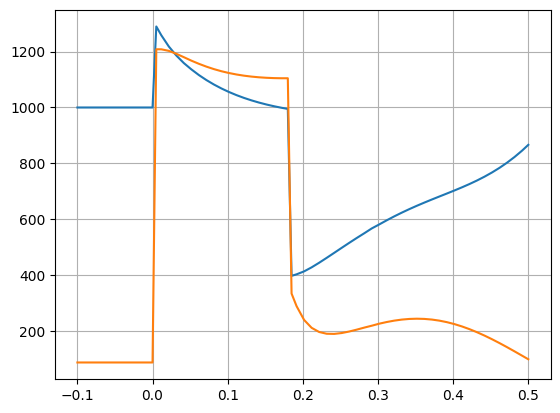

In [25]:
from powfacpy.applications.plots import Plots

plot = Plots.plot_from_csv("Power of Synchronous Machine 01.csv", "G 01\s:P1")
plot = Plots.plot_from_csv("Power of Synchronous Machine 01.csv", "G 01\s:Q1")
plt.grid()

*Pyplot* is used by default, but you can specify a different plot interface using the optional argument `plot_interface`.